In [17]:
import os
import sys
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import timm  # Added for MIM (using MAE from timm)
from torchvision.models import vit_b_16, ViT_B_16_Weights

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_fscore_support

import wandb  # For experiment tracking
import optuna  # For hyperparameter optimization (used later)

import albumentations as A  # For image augmentations
from albumentations.pytorch import ToTensorV2

from pytorch_grad_cam import GradCAM  # For Grad-CAM (used later)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- Self-Supervised Learning Imports ---
from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils #keep for simclr
import pytorch_lightning as pl  # We'll use PyTorch Lightning for easier training
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar #for progress bar

In [18]:
# --- Cell 2: Self-Supervised Learning Imports ---
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vit_b_16, ViT_B_16_Weights
#import lightly # Remove - we're defining SimCLR components ourselves
#from lightly.models.modules.heads import SimCLRProjectionHead # Remove
#from lightly.loss import NTXentLoss # Remove
from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils
import pytorch_lightning as pl  # We'll use PyTorch Lightning for easier training
from pytorch_lightning.callbacks import ModelCheckpoint

In [19]:
# --- Cell 3: Configuration (Updated for MIM and Fine-tuning) ---
import os
import torch

# --- Dataset ---
DATASET_ROOT = "/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection"  # YOUR DATASET PATH.  UPDATE THIS!
ORIGINAL_DIR = os.path.join(DATASET_ROOT, "Original Dataset")
AUGMENTED_DIR = os.path.join(DATASET_ROOT, "Augmented Dataset")

CLASSES = [
    "Bacterial Blight",
    "Curl Virus",
    "Healthy Leaf",
    "Herbicide Growth Damage",
    "Leaf Hopper Jassids",
    "Leaf Redding",
    "Leaf Variegation",
]
NUM_CLASSES = len(CLASSES)
CLASS_MAP = {i: name for i, name in enumerate(CLASSES)}

# --- Training ---
IMAGE_SIZE = (224, 224)  # Model ALWAYS expects 224x224
BATCH_SIZE = 16 # Reduced batch size
LEARNING_RATE = 1e-4
EPOCHS = 10  #  Reduced epochs for faster demonstration
NUM_WORKERS = 6
VAL_SIZE = 0.2
TEST_SIZE = 0.2
RANDOM_STATE = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model ---
MODEL_NAME = "vit_b_16"  #  Keep ViT-B/16 for consistency
PRETRAINED = True
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.pth") # Keep best model.


# ---  MIM Settings (NEW) ---
MIM_MODEL_NAME = "vit_base_patch16_224_mae"  #  Use MAE from timm.  Or, a BEiT model.
MIM_PRETRAINED = True # Use MAE pretrained weights
MASK_RATIO = 0.75  # Example: Mask 75% of patches.  Tune this.
MIM_CHECKPOINT_DIR = "mim_checkpoints"
os.makedirs(MIM_CHECKPOINT_DIR, exist_ok=True)
MIM_CHECKPOINT_PATH = os.path.join(MIM_CHECKPOINT_DIR, f"{MIM_MODEL_NAME}_best.pth")

In [20]:
# --- Cell 4: Data Loading (SSL + MIM) ---
from data_utils import CottonDataset, get_transforms, PILTransform, segment_leaf, create_data_loaders
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- SimCLR Augmentations ---
simclr_transforms = SimCLRTransform(
    input_size=224,  # ViT uses 224x224
    gaussian_blur=0.5,  # Add gaussian blur
)

# --- MIM Augmentations ---
class RandomMasking(A.core.transforms_interface.ImageOnlyTransform):
    def __init__(self, mask_ratio=0.75, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.mask_ratio = mask_ratio

    def apply(self, img, **params):
        mask = np.random.rand(*img.shape[:2]) < self.mask_ratio  # Random mask
        img[mask] = 0  # Replace with 0 (or a learnable token)
        return img

class MIMTransform(A.Compose):
   def __init__(self, image_size, mask_ratio):
        super().__init__([
        A.Resize(height=image_size[0], width=image_size[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # Add more augmentations as needed, but be careful – some might interfere with MIM
        RandomMasking(mask_ratio=mask_ratio, p=1.0), # Always apply masking
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        ])

class MIMDataset(CottonDataset):
    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)  # Get image and label
        return image, label   # Return image and label



# --- Data Loaders ---

# 1. SimCLR
#train_dataset_simclr = CottonDataset(ORIGINAL_DIR, transform=PILTransform(get_transforms(train=True))) # Use PILTransform
#ssl_train_dataset = LightlyDataset.from_torch_dataset(train_dataset_simclr)
# Now, correctly create the LightlyDataset using from_dirname:
ssl_train_dataset = LightlyDataset(input_dir=ORIGINAL_DIR, transform=simclr_transforms)

ssl_train_dataloader = DataLoader(
    ssl_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,  # Important for contrastive learning
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# 2. MIM
mim_train_transforms = MIMTransform(image_size=IMAGE_SIZE, mask_ratio=MASK_RATIO)
mim_train_dataset = MIMDataset(ORIGINAL_DIR, transform=mim_train_transforms)
mim_train_dataloader = DataLoader(
    mim_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,  # Less critical for MIM than for SimCLR, but good practice
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Found 2137 files
First 5 file paths: ['/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00226.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00113.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00102.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00100.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00098.jpg']
Dataset length: 2137
Dataset length: 2137


/home/w2sg-arnav/anaconda3/envs/cotton_env/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [21]:
# --- Cell 5: Model Definitions (ViT and MIM) --- (REVISED)

import torch
import torch.nn as nn
import pytorch_lightning as pl
import timm
from torchvision.models import vit_b_16, ViT_B_16_Weights  # Keep for supervised fine-tuning
from torch.optim import AdamW
from lightly.loss import NTXentLoss #For SimCLR
from lightly.models.modules.heads import SimCLRProjectionHead

# --- ViT Model (using torchvision) --- (Keep this as is)
def get_vit_model(pretrained=True, num_classes=7, dropout_rate=0.0):
    if pretrained:
        weights = ViT_B_16_Weights.DEFAULT
    else:
        weights = None
    model = vit_b_16(weights=weights)
    if num_classes != 1000:
        model.heads = nn.Sequential(
            nn.Linear(model.heads[0].in_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
    return model.to(DEVICE)



# --- SimCLR Projection Head --- (Keep this as is)
class SimCLRProjectionHead(nn.Module):
    def __init__(self, in_dim, hidden_dim=512, out_dim=128):
        super().__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.projection_head(x)

# --- NTXent Loss --- (Keep this as is)
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=2)

    def forward(self, z0, z1):
        batch_size = z0.size(0)
        z = torch.cat([z0, z1], dim=0)
        sim_matrix = self.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        labels = torch.arange(batch_size, device=z.device)
        labels = torch.cat([labels + batch_size, labels])
        loss = nn.functional.cross_entropy(sim_matrix, labels)
        return loss

# --- SimCLR Model (LightningModule) --- (Keep this as is)
class SimCLRModel(pl.LightningModule):
    def __init__(self, backbone, num_ftrs, out_dim=128, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters(ignore=['backbone'])
        self.backbone = backbone
        self.backbone.heads = nn.Identity()  # Remove classification head
        self.projection_head = SimCLRProjectionHead(num_ftrs, out_dim)
        self.criterion = NTXentLoss(temperature=0.5)
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.backbone(x)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch  # Unpack the two augmented views
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer



# --- MIM Model (using timm) --- (MODIFIED for Option 1)
# --- Inside the MIMModel class ---
class MIMModel(pl.LightningModule):
    def __init__(self, model_name="vit_base_patch16_224", pretrained=False, # Default to False
                 checkpoint_path=None,
                 mask_ratio=MASK_RATIO, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters(ignore=['backbone'])

        # 1. Load a standard ViT-Base/16 WITHOUT pretrained weights:
        self.backbone = timm.create_model("vit_base_patch16_224", pretrained=pretrained)
        self.backbone.reset_classifier(0)  # Remove the classification head

        # 2. Load MAE *checkpoint* (you need to download this):
        if pretrained:  # Only load if pretrained=True
            if checkpoint_path is None or not os.path.exists(checkpoint_path):
                raise ValueError(f"Pretrained is True, but checkpoint_path is invalid: {checkpoint_path}")

            try:
                checkpoint = torch.load(checkpoint_path, map_location="cpu")
                # Handle different checkpoint formats:
                checkpoint_model = checkpoint['model'] if 'model' in checkpoint else checkpoint['state_dict']
                # Load the state dict. Use `strict=False`.
                msg = self.backbone.load_state_dict(checkpoint_model, strict=False)
                print(msg)  # Print loading messages

            except Exception as e:
                print(f"Error loading checkpoint: {e}")
                raise  # Re-raise the exception

        # ---  MAE-specific parts (these will need adjustment) ---
        self.mask_token = nn.Parameter(torch.zeros(1, 1, self.backbone.embed_dim)) #Keep as you will need for masking logic
        self.criterion = nn.MSELoss()  # Use MSE loss
        self.learning_rate = learning_rate
        self.mask_ratio = mask_ratio

        # Add unnormalize here
        self.unnormalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )

    def forward(self, x, mask=None):
        # --- Masking (if mask is not provided) ---
        if mask is None:  # During training, we create the mask.
            B, C, H, W = x.shape
            # 1. Create the mask (same logic as in RandomMasking)
            mask = torch.rand(B, H // 16, W // 16, device=x.device) < self.mask_ratio  # [B, h, w]
            # 2.  Expand the mask to match the patch embedding size.
            mask = mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)  # [B, H, W]
            mask = mask.unsqueeze(1).repeat(1, C, 1, 1) # [B, C, H, W], same shape as input

        # --- Apply the mask ---
        x = x * (1 - mask.float()) + self.mask_token * mask.float() # Apply mask

        # --- Forward pass through the backbone ---
        features = self.backbone(x)  # Get features from ViT backbone

        return features, mask  # Return *both* features and mask


    def training_step(self, batch, batch_idx):
        images, _ = batch  # We don't use labels in MIM
        #images = images[0]  # With Lightly, you get a list of views.  For MIM, we just use one.

        # Forward pass to get predictions and the mask.
        predictions, mask = self.forward(images)

        # Get the original, unnormalized images (for loss calculation)
        original_images = images.clone()
        original_images = self.unnormalize(original_images) # Unnormalize

        # --- Loss Calculation (MSE on *masked* patches) ---
        loss = self.criterion(predictions * mask, original_images * mask) #Multiply mask here

        self.log("train_loss_mim", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer


In [22]:
# --- Cell 6: SimCLR Pre-training Setup ---
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar
from data_utils import get_transforms, PILTransform, CottonDataset
from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform

# 1. Create ViT Backbone for SimCLR
vit_backbone_simclr = get_vit_model(pretrained=True)  # Get pre-trained ViT

# Get the correct feature dimension (CORRECTED)
num_ftrs_simclr = vit_backbone_simclr.heads[0].in_features

vit_backbone_simclr.heads = nn.Identity()  # Remove classification head - VERY IMPORTANT

# 2. Create SimCLR Model
simclr_model = SimCLRModel(vit_backbone_simclr, num_ftrs=num_ftrs_simclr)

# 3. Create Data Loader for SimCLR (using the SimCLRTransform)
#     NOTE:  We use the *training* transforms from first.ipynb, PLUS the SimCLR-specific augmentations
train_transforms = get_transforms(train=True)  # Standard training transforms
simclr_train_dataset = CottonDataset(ORIGINAL_DIR, transform=PILTransform(train_transforms))  # First apply standard transforms
ssl_train_dataset = LightlyDataset.from_torch_dataset(simclr_train_dataset, transform=simclr_transforms) # Then apply SimCLR transforms

ssl_train_dataloader = DataLoader(
    ssl_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,  # Important for contrastive learning
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# 4. Train SimCLR Model (using PyTorch Lightning)
trainer_simclr = pl.Trainer(
    max_epochs=10,  # Adjust as needed (can use fewer epochs for pre-training)
    devices=1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    default_root_dir="ssl_checkpoints",  # Save checkpoints in a separate directory
    enable_progress_bar=True,
    # callbacks=[RichProgressBar()]  # Optional: Use RichProgressBar for nicer output
)
trainer_simclr.fit(simclr_model, ssl_train_dataloader)

# 5. Save Pre-trained Backbone (after SimCLR)
torch.save(simclr_model.backbone.state_dict(), "pretrained_vit_backbone_simclr.pth")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | backbone        | VisionTransformer    | 85.8 M | train
1 | projection_head | SimCLRProjectionHead | 114 K  | train
2 | criterion       | NTXentLoss           | 0      | train
-----------------------------------------------------------------
85.9 M    Trainable params
0         Non-trainable params
85.9 M    Total params
343.654   Total estimated model params size (MB)
158       Modules in train mode
0         Modules in eval mode


Found 2137 files
First 5 file paths: ['/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00226.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00113.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00102.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00100.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00098.jpg']
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137


Training: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x791508b93c10>
Traceback (most recent call last):
  File "/home/w2sg-arnav/anaconda3/envs/cotton_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/w2sg-arnav/anaconda3/envs/cotton_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/w2sg-arnav/anaconda3/envs/cotton_env/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/w2sg-arnav/anaconda3/envs/cotton_env/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/w2sg-arnav/anaconda3/envs/cotton_env/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/w2sg-arnav/anaconda3/envs/cotton_env/lib/pyth

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 0 has a total capacity of 5.68 GiB of which 12.94 MiB is free. Including non-PyTorch memory, this process has 5.64 GiB memory in use. Of the allocated memory 5.33 GiB is allocated by PyTorch, and 202.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [23]:
checkpoint = torch.load(checkpoint_path, map_location="cpu")
print(f"Keys in checkpoint: {checkpoint.keys()}")

Keys in checkpoint: odict_keys(['class_token', 'conv_proj.weight', 'conv_proj.bias', 'encoder.pos_embedding', 'encoder.layers.encoder_layer_0.ln_1.weight', 'encoder.layers.encoder_layer_0.ln_1.bias', 'encoder.layers.encoder_layer_0.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_0.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_0.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_0.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_0.ln_2.weight', 'encoder.layers.encoder_layer_0.ln_2.bias', 'encoder.layers.encoder_layer_0.mlp.0.weight', 'encoder.layers.encoder_layer_0.mlp.0.bias', 'encoder.layers.encoder_layer_0.mlp.3.weight', 'encoder.layers.encoder_layer_0.mlp.3.bias', 'encoder.layers.encoder_layer_1.ln_1.weight', 'encoder.layers.encoder_layer_1.ln_1.bias', 'encoder.layers.encoder_layer_1.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_1.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_1.self_attention.out_proj.

In [24]:
# --- Cell 7: MIM Pre-training (Requires Full MIM Implementation) ---
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from data_utils import CottonDataset, PILTransform, get_transforms  # Import get_transforms
import timm
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

# Define constants from Cell 3 (ensure these are already defined)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_WORKERS = 6
MASK_RATIO = 0.75
MIM_MODEL_NAME = "vit_base_patch16_224"  # or your specific MAE model name
MIM_CHECKPOINT_DIR = "mim_checkpoints"
os.makedirs(MIM_CHECKPOINT_DIR, exist_ok=True)
MIM_CHECKPOINT_PATH = os.path.join(MIM_CHECKPOINT_DIR, f"{MIM_MODEL_NAME}_best.pth")


# --- MIM Augmentations (Define here since used by the dataset)---
class RandomMasking(A.core.transforms_interface.ImageOnlyTransform):
    def __init__(self, mask_ratio=0.75, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.mask_ratio = mask_ratio

    def apply(self, img, **params):
        mask = np.random.rand(*img.shape[:2]) < self.mask_ratio  # Random mask
        img[mask] = 0  # Replace with 0 (or a learnable token)
        return img

class MIMTransform(A.Compose):
   def __init__(self, image_size, mask_ratio):
        super().__init__([
        A.Resize(height=image_size[0], width=image_size[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        RandomMasking(mask_ratio=mask_ratio, p=1.0), # Always apply masking
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        ])

class MIMDataset(CottonDataset):
    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)  # Get image and label
        return image, label   # Return image and label

# 1. Create MIM Data Loader
mim_train_transforms = MIMTransform(image_size=IMAGE_SIZE, mask_ratio=MASK_RATIO)
mim_train_dataset = MIMDataset(ORIGINAL_DIR, transform=PILTransform(mim_train_transforms))
mim_train_dataloader = DataLoader(
    mim_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,  # Less critical for MIM than for SimCLR, but good practice
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Found 2137 files
First 5 file paths: ['/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00226.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00113.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00102.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00100.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Healthy Leaf/HL00098.jpg']
Dataset length: 2137
Dataset length: 2137


In [2]:
# --- Cell 8/9: Supervised Fine-tuning - Model Definition and Training ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from data_utils import create_data_loaders, get_transforms, CottonDataset
from torchvision.models import vit_b_16, ViT_B_16_Weights  #For ViT model
import os
import glob
from PIL import Image
import numpy as np


# Define constants (adjust as needed)
ORIGINAL_DIR = "/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_WORKERS = 6
CLASSES = [
    "Bacterial Blight",
    "Curl Virus",
    "Healthy Leaf",
    "Herbicide Growth Damage",
    "Leaf Hopper Jassids",
    "Leaf Redding",
    "Leaf Variegation",
]
NUM_CLASSES = len(CLASSES)
EPOCHS = 10 # You might need to define this.

# Define the FineTuneModel
class FineTuneModel(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4, weight_decay=1e-4):  # Added weight_decay
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay # Added for optimizer
        self.validation_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(self.device)  # Use self.device for Lightning
        labels = labels.to(self.device)
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(self.device)
        labels = labels.to(self.device)
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.validation_outputs.append(loss)  # Store validation outputs
        return loss

    def on_validation_epoch_end(self):
        # Compute average validation loss
        avg_loss = torch.stack(self.validation_outputs).mean()
        self.log('val_loss_epoch', avg_loss, on_epoch=True)  # Use on_epoch_end
        self.validation_outputs.clear()  # Clear the list for the next epoch.

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6) # Example parameters
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',  # or 'step', depending on your needs
                'frequency': 1
            }
        }

In [3]:
# --- Cell 8: Supervised Fine-tuning (LightningModule) ---\n",
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import pytorch_lightning as pl
from data_utils import create_data_loaders, get_transforms, CottonDataset
from torchvision.models import vit_b_16, ViT_B_16_Weights #For ViT model


class FineTuneModel(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4, weight_decay=1e-4):  # Added weight_decay
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay # Added for optimizer
        self.validation_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(self.device)  # Use self.device for Lightning
        labels = labels.to(self.device)
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(self.device)
        labels = labels.to(self.device)
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.validation_outputs.append(loss)  # Store validation outputs
        return loss

    def on_validation_epoch_end(self):
        # Compute average validation loss
        avg_loss = torch.stack(self.validation_outputs).mean()
        self.log('val_loss_epoch', avg_loss, on_epoch=True)  # Use on_epoch_end
        self.validation_outputs.clear()  # Clear the list for the next epoch.

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6) # Example parameters
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',  # or 'step', depending on your needs
                'frequency': 1
            }
        }

In [5]:
# --- Cell 9:  Main Fine-Tuning Section ---\n",
from pytorch_lightning.callbacks import ModelCheckpoint

#  Data Loaders (use standard train/val loaders, NOT the SSL loaders)
train_transforms = get_transforms(train=True)
val_transforms = get_transforms(train=False)

train_loader, val_loader, test_loader = create_data_loaders(
    ORIGINAL_DIR, train_transforms, val_transforms, BATCH_SIZE, NUM_WORKERS, CLASSES
)

# Load the ViT Backbone (either from ImageNet or from your SSL pre-training)
#    Choose *ONE* of the following loading options:

# Option A: Load from ImageNet pre-trained weights:
finetune_model = get_vit_model(num_classes=NUM_CLASSES)  # Get pre-trained ViT with a custom head
#  (No need to load_state_dict here, as get_vit_model already loads ImageNet weights)

# Option B: Load from SimCLR pre-trained weights:
# finetune_model = get_vit_model(pretrained=False, num_classes=NUM_CLASSES)  #  NO pretrained weights here
# vit_backbone = get_vit_model(pretrained=False)  # Create a backbone WITHOUT a head
# vit_backbone.load_state_dict(torch.load("pretrained_vit_backbone_simclr.pth"))  # Load SimCLR weights
# vit_backbone.heads = nn.Identity()
# finetune_model.model.backbone = vit_backbone

# Option C: Load from MIM pre-trained weights:\n",
# finetune_model = get_vit_model(pretrained=False, num_classes=NUM_CLASSES)
# vit_backbone = timm.create_model(MIM_MODEL_NAME, pretrained=False) # Create backbone from timm
# vit_backbone.load_state_dict(torch.load("pretrained_vit_backbone_mim.pth"))
# finetune_model.model.backbone = vit_backbone # Load weights into the backbone.
# # You might need to adapt this, depending on how `timm` handles the head.

# Freeze Backbone (optional, but often helpful for fine-tuning)
for name, param in finetune_model.named_parameters():
    if "heads" not in name:  # Only unfreeze the classification head
        param.requires_grad = True #UNFREEZE here



# Wrap with FineTuneModel (your LightningModule)
finetune_pl_model = FineTuneModel(finetune_model)

# Create PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    devices=1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    default_root_dir="finetune_checkpoints",
    callbacks=[ModelCheckpoint(filename='best_model_{epoch}-{val_loss_epoch:.2f}',monitor="val_loss_epoch",save_top_k=1,mode="min")] # Add ModelCheckpoint
)

# Train the model
trainer.fit(finetune_pl_model, train_loader, val_loader)

#  Save the fine-tuned model
torch.save(finetune_pl_model.model.state_dict(), "finetuned_vit.pth") #saving state dict of the model

--- Loaded File Paths (First 5 of each) ---
Train: ['/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Bacterial Blight/BBC00155.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Herbicide Growth Damage/HGD00260.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Curl Virus/CV00202.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Herbicide Growth Damage/HGD00203.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Bacterial Blight/BBC00184.jpg']
Validation: ['/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Herbicide Growth Damage/HGD00095.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | VisionTransformer | 85.8 M | train
1 | criterion | CrossEntropyLoss  | 0      | train
--------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.216   Total estimated model params size (MB)
153       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137
Dataset length: 2137
__getitem__: idx = 128, len(self.labels) = 2137__getitem__: idx = 160, len(self.labels) = 2137__getitem__: idx = 64, len(self.labels) = 2137__getitem__: idx = 96, len(self.labels) = 2137__getitem__: idx = 0, len(self.labels) = 2137




__getitem__: idx = 32, len(self.labels) = 2137
__getitem__: idx = 161, len(self.labels) = 2137__getitem__: idx = 1, len(self.labels) = 2137__getitem__: idx = 65, len(self.labels) = 2137__getitem__: idx = 33, len(self.labels) = 2137


__getitem__: idx = 97, len(self.labels) = 2137
__getitem__: idx = 129, len(self.labels) = 2137

Dataset length: 2137
Dataset length: 2137
__getitem__: idx = 34, len(self.labels) = 2137__getitem__: idx = 2, len(self.labels) = 2137__getitem__: idx = 162, len(self.labels) = 2137__getitem__: idx = 130, len(self.labels) = 2137
__getitem__: idx = 66, len(self.labels) = 2137


__getitem__: idx = 98, len(self.labels) = 2137

__getitem__: idx = 3, len(self.labels) = 2137__getitem__: idx = 131

AttributeError: 'list' object has no attribute 'to'

In [ ]:
# --- Cell 10: Load Best Fine-tuned Model ---

# Find the best checkpoint file
checkpoint_dir = "finetune_checkpoints"
checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "*.ckpt"))

if checkpoint_files:
    # Find the checkpoint with the lowest validation loss
    best_checkpoint = min(checkpoint_files, key=lambda x: float(x.split("=")[-1].split(".ckpt")[0]))
    print(f"Loading best checkpoint: {best_checkpoint}")

    # Load the best model checkpoint
    # IMPORTANT:  Pass the `model` argument correctly!
    loaded_model = FineTuneModel.load_from_checkpoint(best_checkpoint, model=get_vit_model(num_classes=NUM_CLASSES))
    loaded_model.eval()  # Set to evaluation mode
    loaded_model.to(DEVICE) # Move to the correct device
else:
    print("No checkpoint files found.  Make sure you trained the model and checkpoints were saved.")
    loaded_model = None # Set to None to avoid errors later

In [ ]:
# --- Cell 11: Prediction on a Single Image (Example) ---
import numpy as np
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
def predict_single_image(model, image_path, transform):
    """Predicts the class of a single image.

    Args:
        model: The trained PyTorch model.
        image_path: Path to the image file.
        transform: The transformation to apply to the image.

    Returns:
        predicted_class: The predicted class index.
        probabilities: A tensor of class probabilities.
    """
    image = Image.open(image_path).convert("RGB")
    # Apply the validation transforms
    image = transform(image=np.array(image))['image']
    image = image.unsqueeze(0).to(DEVICE)  # Add batch dimension and move to device

    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    return predicted_class, probabilities.cpu().numpy()


# Example usage (check if the model loaded correctly):
if loaded_model is not None:
    # Use a valid path to an image in your test set
    image_path_to_predict =  "/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Bacterial Blight/BBC00024.jpg"

    if os.path.exists(image_path_to_predict):
        predicted_class, probabilities = predict_single_image(loaded_model.model, image_path_to_predict, val_transforms)

        print(f"Predicted Class: {CLASSES[predicted_class]}")
        print(f"Probabilities: {probabilities}")

        # Display the image (optional):
        img = Image.open(image_path_to_predict)
        plt.imshow(img)
        plt.title(f"Predicted: {CLASSES[predicted_class]}")
        plt.show()
    else:
        print(f"Error: Image file not found at {image_path_to_predict}")
else:
    print("Error: Model was not loaded successfully. Cannot make predictions.")

Dataset length: 2137
Dataset length: 2137
Images shape: torch.Size([16, 3, 224, 224])
Labels: ['Leaf Hopper Jassids', 'Herbicide Growth Damage', 'Leaf Variegation', 'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation', 'Herbicide Growth Damage', 'Herbicide Growth Damage', 'Leaf Hopper Jassids', 'Leaf Redding', 'Healthy Leaf', 'Leaf Redding', 'Leaf Redding', 'Curl Virus', 'Herbicide Growth Damage', 'Leaf Hopper Jassids']
Metadata: ['539', '1325', '311', '401', '926', '345', '1263', '1295', '442', '882', '137', '992', '1028', '1751', '1413', '577']


In [ ]:
# --- Cell 12: Comprehensive Evaluation - Setup ---
#from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
#import matplotlib.pyplot as plt
#import seaborn as sns
# These were all imported in Cell 1

finetune_pl_model.model.eval()  # Switch to evaluation mode
test_preds = []
test_true = []
test_probs = []  # For ROC and PR curves

--- Loaded File Paths (First 5 of each) ---
Train: ['/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Bacterial Blight/BBC00155.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Herbicide Growth Damage/HGD00260.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Curl Virus/CV00202.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Herbicide Growth Damage/HGD00203.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Bacterial Blight/BBC00184.jpg']
Validation: ['/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Herbicide Growth Damage/HGD00095.jpg', '/home/w2sg-arnav/8-phases/SAR-CLD-2024

In [ ]:
# --- Cell 13: Prediction Loop (on Test Set) ---

# Assuming CLASSES is a list of class names, e.g., ['Bacterial Blight', 'Curl Virus', ...]
#class_to_idx = {cls: i for i, cls in enumerate(CLASSES)}  # Map class names to indices #moved inside the loop
#This is now part of data_utils, so no need to define again.

# Move the model to the correct device (GPU or CPU)
finetune_pl_model.model.to(DEVICE) #This was already done during loading.

# Prediction loop
with torch.no_grad():  # Disable gradient calculation during evaluation
    for images, labels in test_loader: #no metadata
        # Move images to the correct device
        images = images.to(DEVICE)

        # Convert string labels to integer indices and move to the correct device
        if isinstance(labels[0], str):  # Check if labels are strings
            labels = torch.tensor([CLASS_MAP[label] for label in labels], dtype=torch.long).to(DEVICE)
        else:
            labels = labels.to(DEVICE) # Ensure labels are on the correct device, even if they are already tensors.

        # Forward pass through the model
        outputs = finetune_pl_model.model(images)

        # Get predicted class indices
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions, true labels, and probabilities
        test_preds.extend(predicted.cpu().numpy())
        test_true.extend(labels.cpu().numpy()) #Use the integer indices.
        test_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

# Convert probabilities to a NumPy array
test_probs = np.array(test_probs)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
# --- Cell 14: Basic Evaluation Metrics ---

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate overall accuracy
accuracy = accuracy_score(test_true, test_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score (macro average)
precision, recall, f1, _ = precision_recall_fscore_support(test_true, test_preds, average='macro', zero_division=0)
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")


# Log to WandB
if wandb.run is not None:  # Check if wandb is initialized
    wandb.log({
        "test_accuracy": accuracy,
        "test_precision": precision,
        "test_recall": recall,
        "test_f1": f1,
    })

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# --- Cell 15: Classification Report ---

# Generate and print the classification report
report = classification_report(test_true, test_preds, target_names=CLASSES, zero_division=0)
print("\\n--- Classification Report ---\\n")
print(report)

# Convert to DataFrame for easier logging/saving
report_df = pd.DataFrame(classification_report(test_true, test_preds, target_names=CLASSES, zero_division=0, output_dict=True)).transpose()

# Log to WandB (if initialized)
if wandb.run is not None:
    wandb.log({"classification_report": wandb.Table(dataframe=report_df)})

In [ ]:
# --- Cell 14: Supervised Fine-tuning - Training Execution ---
# Wrap the fine-tune model
finetune_pl_model = FineTuneModel(finetune_model) #instantiate model
# Train the model
trainer.fit(finetune_pl_model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | VisionTransformer | 85.8 M | eval 
1 | criterion | CrossEntropyLoss  | 0      | train
--------------------------------------------------------
5.4 K     Trainable params
85.8 M    Non-trainable params
85.8 M    Total params
343.216   Total estimated model params size (MB)
1         Modules in train mode
152       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137


Training: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137


/home/w2sg-arnav/anaconda3/envs/cotton_env/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Dataset length: 2137
Dataset length: 2137


Validation: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137


Validation: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137


Validation: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137


Validation: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137


Validation: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137


Validation: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137


Validation: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137


Validation: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137


Validation: |          | 0/? [00:00<?, ?it/s]

Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137
Dataset length: 2137


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Dataset length: 2137
Dataset length: 2137


In [ ]:
# --- Cell 16: Confusion Matrix ---
import seaborn as sns

conf_mat = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Log to WandB
if wandb.run is not None:
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
        probs=None, y_true=test_true, preds=test_preds, class_names=CLASSES
    )})

train_acc,▁▄▆▇▅▃▆▃▆▅▇▇█▇▆▃█▆▆▆▆▆▆█▆▇▆▆▆▇▆▇▇▅▇▆▆▆▆▆
train_loss,█▅▅▅▄▃▃▂▂▃▂▂▃▂▃▂▂▃▁▂▂▃▃▂▂▁▁▂▁▂▂▂▂▂▂▂▂▁▂▂
val_acc,▁▂▇▂▆▅█▆▂█▅▅██▃███▆█▇█▁▅▇█▅▃█▇▇▇█▇▇▅▇▃▆▃
val_loss,▇▇▆▃▇▅▆▄▅▄▄▅▄▅▄▅▂▄▄▄▃▁▃▄▃▂▂▃▂▃▂▁▁█▃▃▃█▄▂
train_acc,0.88889
train_loss,0.38552
val_acc,0.77778
val_loss,0.69053


In [ ]:
# --- Cell 17: ROC Curve and AUC ---

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(test_true_indices == i, test_probs[:, i])  # Treat each class as binary
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{CLASSES[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Log to WandB
if wandb.run is not None:
    wandb.log({"roc": wandb.plot.roc_curve(test_true_indices, test_probs, CLASSES)})

In [ ]:
# --- Cell 18: Precision-Recall Curve ---

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    precision, recall, _ = precision_recall_curve(test_true_indices == i, test_probs[:, i])
    ap = average_precision_score(test_true_indices == i, test_probs[:, i])
    plt.plot(recall, precision, label=f'{CLASSES[i]} (AP = {ap:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Log to WandB
if wandb.run is not None:
    wandb.log({"pr": wandb.plot.pr_curve(test_true_indices, test_probs, CLASSES)})

In [ ]:
# --- Cell 19: Save Evaluation Results ---

# Save Results to Files
eval_dir = "evaluation_results"
os.makedirs(eval_dir, exist_ok=True)

# Save classification report (already a DataFrame)
report_df.to_csv(os.path.join(eval_dir, "classification_report.csv"))

# Save confusion matrix
conf_mat_df = pd.DataFrame(conf_mat, index=CLASSES, columns=CLASSES)
conf_mat_df.to_csv(os.path.join(eval_dir, "confusion_matrix.csv"))

# You *could* also save the ROC and PR data to CSV files if you wanted to
# do further analysis outside of this notebook, but it's usually sufficient
# to have the plots and the WandB logs.

Dataset length: 2137


                         precision    recall  f1-score   support

       Bacterial Blight       0.84      0.84      0.84       250
             Curl Virus       0.91      0.91      0.91       431
           Healthy Leaf       0.88      0.94      0.91       257
Herbicide Growth Damage       0.99      1.00      0.99       280
    Leaf Hopper Jassids       0.79      0.67      0.72       225
           Leaf Redding       0.84      0.88      0.86       578
       Leaf Variegation       1.00      0.93      0.96       116

               accuracy                           0.88      2137
              macro avg       0.89      0.88      0.89      2137
           weighted avg       0.88      0.88      0.88      2137



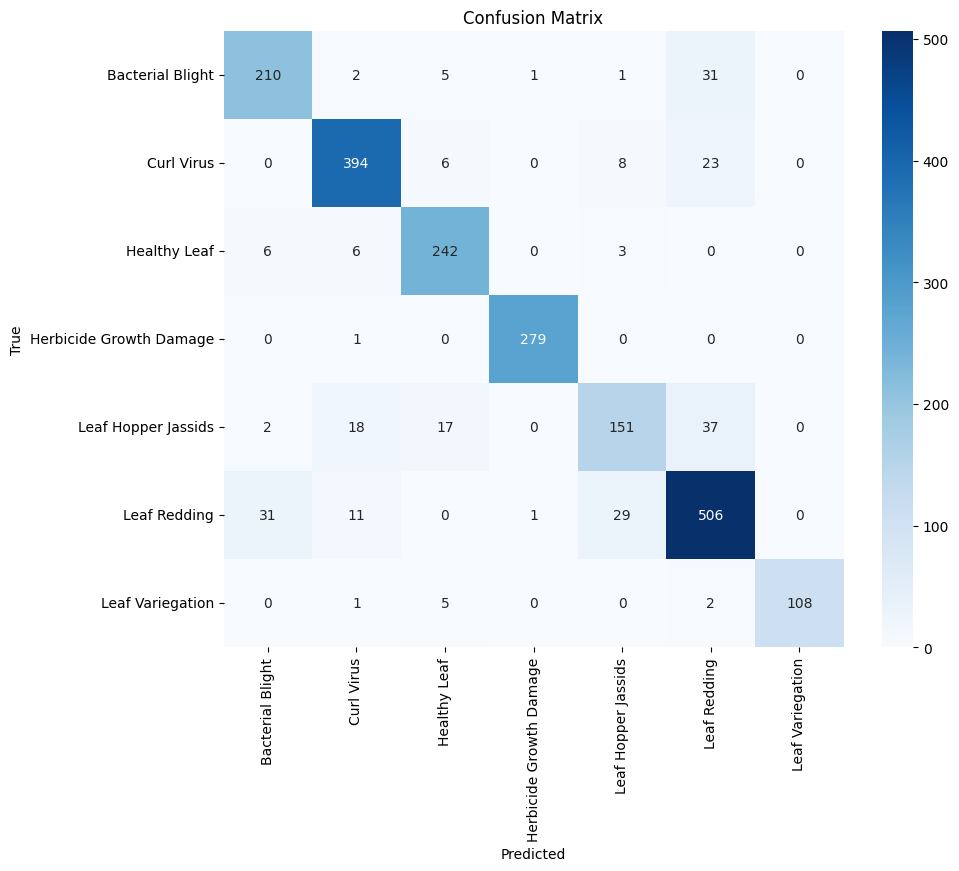

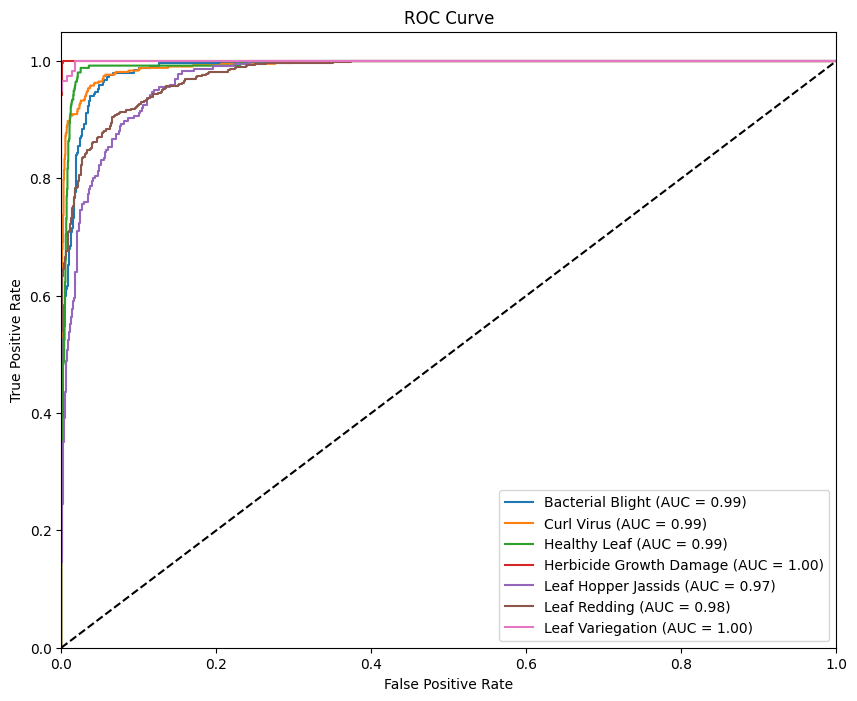

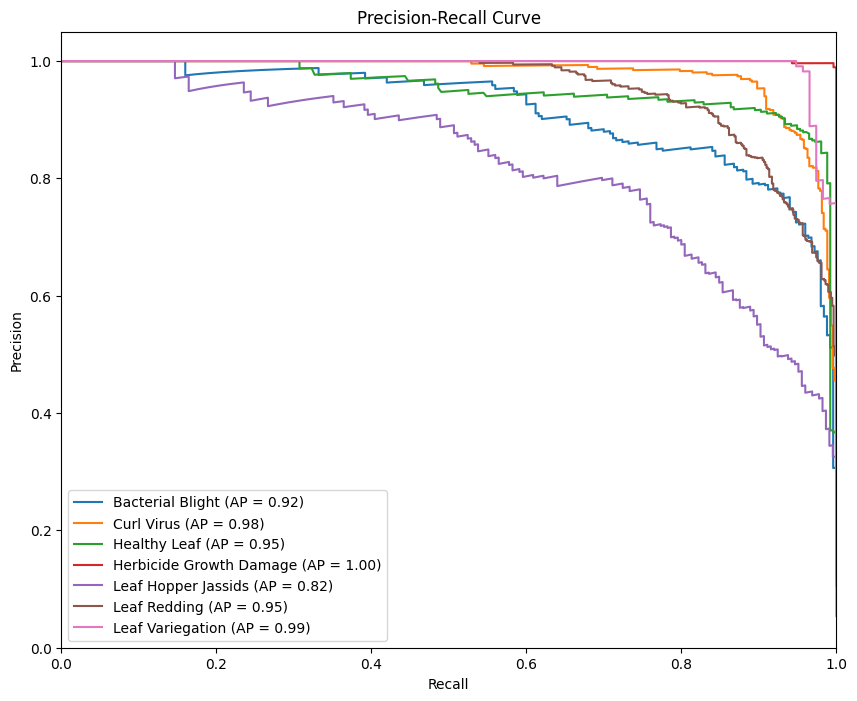

In [ ]:
# --- Cell 20: Finish W&B Run ---
wandb.finish()

In [ ]:
# --- Cell 21: Reload Best Checkpoint (Redundant but Good Practice) ---

# Find the best checkpoint file
checkpoint_dir = "finetune_checkpoints"  # Make sure this matches your training setup
checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "*.ckpt"))

if checkpoint_files:
    best_checkpoint = min(checkpoint_files, key=lambda x: float(x.split("=")[-1].split(".ckpt")[0]))
    print(f"Loading best checkpoint: {best_checkpoint}")

    # Load the *entire* LightningModule, which includes the model and hyperparameters
    loaded_model = FineTuneModel.load_from_checkpoint(best_checkpoint, model=get_vit_model(num_classes=NUM_CLASSES))
    loaded_model.eval()  # Set to evaluation mode
    loaded_model.to(DEVICE)
else:
    print("No checkpoint files found.  Make sure you trained the model and checkpoints were saved.")
    loaded_model = None

In [ ]:
# --- Cell 22: Prediction on a Single Image (Example) ---
# (Keep this function as it is - it's well-written)
def predict_single_image(model, image_path, transform):
    """Predicts the class of a single image.

    Args:
        model: The trained PyTorch model.
        image_path: Path to the image file.
        transform: The transformation to apply to the image.

    Returns:
        predicted_class: The predicted class index.
        probabilities: A tensor of class probabilities.
    """
    image = Image.open(image_path).convert("RGB")
    # Apply the validation transforms
    image = transform(image=np.array(image))['image']
    image = image.unsqueeze(0).to(DEVICE)  # Add batch dimension and move to device

    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    return predicted_class, probabilities.cpu().numpy()

Loading best checkpoint: finetune_checkpoints/epoch=9-val_loss_epoch=0.33.ckpt


Predicted Class: Herbicide Growth Damage
Probabilities: [[1.5158847e-03 2.7804303e-03 2.9996820e-03 9.8948413e-01 2.0476079e-03
  7.2013447e-04 4.5214157e-04]]


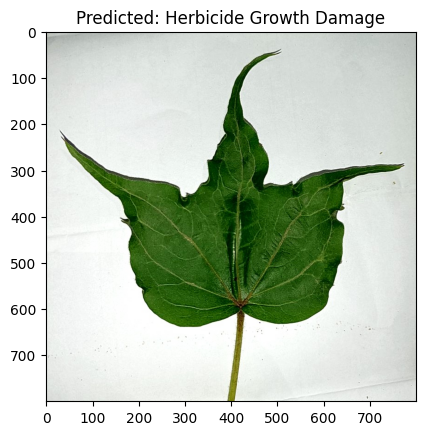

In [ ]:
# --- Cell 23: Single Image Prediction (Example Usage) ---

# Example usage (check if the model loaded correctly):
if loaded_model is not None:
  # Use a valid path to an image in your *test set*
  image_path_to_predict =  "/home/w2sg-arnav/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Bacterial Blight/BBC00024.jpg"  #CHANGE THIS

  if os.path.exists(image_path_to_predict):
    predicted_class, probabilities = predict_single_image(loaded_model.model, image_path_to_predict, val_transforms)

    print(f"Predicted Class: {CLASSES[predicted_class]}")
    print(f"Probabilities: {probabilities}")

    # Display the image (optional):
    img = Image.open(image_path_to_predict)
    plt.imshow(img)
    plt.title(f"Predicted: {CLASSES[predicted_class]}")
    plt.show()
  else:
    print(f"Error: Image file not found at {image_path_to_predict}")
else:
  print("Error: Model was not loaded successfully. Cannot make predictions.")

In [ ]:
# --- Cell 24: Grad-CAM Visualization (Setup) ---

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Choose a target layer.  For ViT, you want an attention block.
# Example:  (This might need adjustment depending on your ViT variant)
target_layers = [loaded_model.model.model.blocks[-1].norm1]  # Last layer's normalization

# Create GradCAM object
cam = GradCAM(model=loaded_model.model.model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

In [ ]:
# --- Cell 25: Grad-CAM Visualization (Execution and Display) ---
import cv2
# Choose an image for visualization (use the SAME image as in Cell 23)
image_path = image_path_to_predict  # Use the same image as the prediction example

# Load and preprocess the image
input_tensor = get_transforms(train=False)(image=np.array(Image.open(image_path).convert("RGB")))['image'].unsqueeze(0)
input_tensor = input_tensor.to(DEVICE)

# Get the target category (or use None for the predicted category)
targets = [ClassifierOutputTarget(predicted_class)]   #  Use  the predicted class


# Generate the CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]  # Remove batch dimension

# Visualize
img = cv2.imread(image_path, 1)[:, :, ::-1]  # Read and convert to RGB
img = np.float32(img) / 255
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.show()